In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from torch._utils import _accumulate
def random_split(dataset, lengths):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    Arguments:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths of splits to be produced
    """
    if sum(lengths) != len(dataset):
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = torch.randperm(sum(lengths))
    return [torch.utils.data.Subset(dataset, indices[offset - length:offset]) for offset, length in zip(_accumulate(lengths), lengths)]

## FashionMNIST

In [3]:
dl_train = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('../data/f_mnist', train=True, download=True))

dl_test  = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('../data/f_mnist', train=False, download=True))

Using downloaded and verified file: ../data/f_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting ../data/f_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/f_mnist/FashionMNIST/raw


Extracting ../data/f_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/f_mnist/FashionMNIST/raw


Extracting ../data/f_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/f_mnist/FashionMNIST/raw


Extracting ../data/f_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/f_mnist/FashionMNIST/raw
Processing...
Done!



/Users/distiller/project/conda/conda-bld/pytorch_1591914893314/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
data   = dl_train.dataset.data.to(dtype=torch.float32)
labels = dl_train.dataset.targets

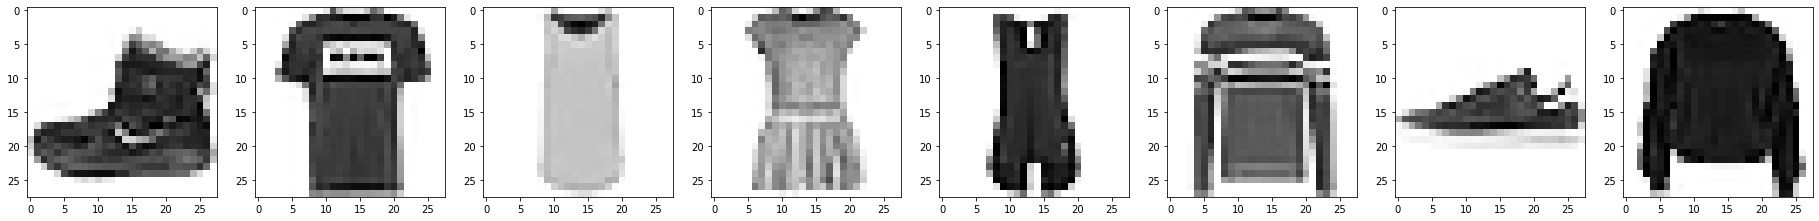

In [5]:
fig_mnist, ax = plt.subplots(1,8, figsize=(8*4,4))
for i in range(8):
    ax[i].imshow(data[i].numpy(), cmap='Greys');

|Label|Description|
|-----|-----------|
| 0  |T-shirt/top| 
| 1  | Trouser   |
| 2  | Pullover  |
| 3  | Dress     |
| 4  | Coat      |
| 5  | Sandal   |
| 6  | Shirt    |
|7 | Sneaker|
|8| Bag |
|9| Ankle boot|

In [6]:
labels[0:8]

tensor([9, 0, 0, 3, 0, 2, 7, 2])

In [7]:
dataset = torch.utils.data.TensorDataset( 
    (data/256.0).view(-1,28*28), 
    labels)

In [8]:
train_dataset, validation_dataset = random_split(dataset, (50000,10000))

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

In [10]:
datasets = [
    torch.utils.data.Subset(train_dataset,torch.randint(len(train_dataset),(len(train_dataset),))) for i in range(5)]

In [11]:
train_loaders = [torch.utils.data.DataLoader(d, 
                                           batch_size=100, 
                                           shuffle=True) for d in datasets]

In [12]:
test_data   = dl_test.dataset.data.to(dtype=torch.float32)
test_labels = dl_test.dataset.targets
test_dataset = torch.utils.data.TensorDataset(
    (test_data/256.0).view(-1,28*28), test_labels)

In [13]:
models = [torch.nn.Sequential(
    nn.Linear(28*28,1200), nn.ReLU(),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.Linear(1200,10)
) for i in range(len(datasets))]

In [14]:
optims = [torch.optim.SGD(models[i].parameters(), lr=0.01, momentum=0.6) for i in range(len(datasets))]

In [15]:
loss_f = nn.CrossEntropyLoss()

In [16]:
%%time
for i in range(len(datasets)):
    for e in range(10):
        for d in train_loaders[i]:        
            optims[i].zero_grad()
            features, labels = d
            pred = models[i](features)
            loss = loss_f(pred, labels)
            loss.backward()
            optims[i].step()
        print(i,e,loss.item())        

0 0 1.1347547769546509
0 1 0.4568258225917816
0 2 0.6285406947135925
0 3 0.4487871527671814
0 4 0.4679567217826843
0 5 0.36799731850624084
0 6 0.36184942722320557
0 7 0.2979765832424164
0 8 0.30160751938819885
0 9 0.3309340178966522
1 0 0.7715571522712708
1 1 0.614430844783783
1 2 0.44799643754959106
1 3 0.49453139305114746
1 4 0.3456646800041199
1 5 0.4797808527946472
1 6 0.31778356432914734
1 7 0.34466731548309326
1 8 0.3740965723991394
1 9 0.3070373237133026
2 0 0.8484892249107361
2 1 0.6551143527030945
2 2 0.5980786681175232
2 3 0.47723567485809326
2 4 0.39321964979171753
2 5 0.5370053648948669
2 6 0.3839387595653534
2 7 0.35817456245422363
2 8 0.3870549499988556
2 9 0.43846595287323
3 0 0.7723106145858765
3 1 0.6550522446632385
3 2 0.4526214301586151
3 3 0.3860251307487488
3 4 0.4537869989871979
3 5 0.33238789439201355
3 6 0.33841314911842346
3 7 0.28189364075660706
3 8 0.3592987358570099
3 9 0.27516981959342957
4 0 0.888871431350708
4 1 0.5899589657783508
4 2 0.5217444896697998
4

In [17]:
with torch.no_grad():
    for i in range(len(datasets)):
        pred = torch.softmax(models[i](datasets[i][:][0]),1)
        ac = torch.sum(torch.argmax(pred,1)==datasets[i][:][1]).to(dtype=torch.float32)/len(datasets[i])
        print(ac)  

tensor(0.8797)
tensor(0.8787)
tensor(0.8843)
tensor(0.8756)
tensor(0.8739)


In [18]:
with torch.no_grad():
    for i in range(len(datasets)):
        pred = torch.softmax(models[i](validation_dataset[:][0]),1)
        ac = torch.sum(torch.argmax(pred,1)==validation_dataset[:][1]).to(dtype=torch.float32)/len(test_dataset)
        print(ac)    

tensor(0.8596)
tensor(0.8627)
tensor(0.8660)
tensor(0.8621)
tensor(0.8571)


In [19]:
def predict_class (model, inp):
    pred = torch.softmax(model(inp),dim=1)
    return torch.argmax(pred,dim=1)

In [20]:
preds = [predict_class(models[i], validation_dataset[:][0]) for i in range(len(datasets))]

In [21]:
preds

[tensor([6, 2, 3,  ..., 0, 7, 8]),
 tensor([6, 2, 3,  ..., 0, 7, 8]),
 tensor([6, 2, 3,  ..., 0, 7, 8]),
 tensor([6, 2, 3,  ..., 0, 7, 8]),
 tensor([6, 2, 3,  ..., 0, 7, 8])]

In [22]:
def vote(predictions):
    npred=torch.stack(predictions, dim=1).numpy()
    v  = np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, npred)
    return torch.from_numpy(v)  

In [23]:
gold = vote(preds)

In [24]:
torch.sum(gold==validation_dataset[:][1]).item()/len(gold)

0.8663

## Dropout 

<p style="text-align:center"><img style="padding:24pt" src="dropout.png"/></p>

In [25]:
model = torch.nn.Sequential(
    nn.Linear(28*28,1200), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1200,10)
)

In [26]:
optim = torch.optim.SGD(model.parameters(), lr=0.01 , momentum=0.6)

In [27]:
model.train()
for e in range(10):
        for d in train_loader:        
            optim.zero_grad()
            features, labels = d
            pred = model(features)
            loss = loss_f(pred, labels)
            loss.backward()
            optim.step()
        print(e,loss.item())        

0 0.9519996643066406
1 0.6941864490509033
2 0.5505940914154053
3 0.47879746556282043
4 0.7312870621681213
5 0.4455671012401581
6 0.5131936073303223
7 0.38850337266921997
8 0.4207405149936676
9 0.5679695010185242


In [28]:
model.eval()
pred = torch.softmax(model(train_dataset[:][0]),1)
ac = torch.sum(torch.argmax(pred,1)==train_dataset[:][1]).to(dtype=torch.float32)/len(train_dataset)
print(ac)
pred = torch.softmax(model(validation_dataset[:][0]),1)
ac = torch.sum(torch.argmax(pred,1)==validation_dataset[:][1]).to(dtype=torch.float32)/len(validation_dataset)
print(ac)

tensor(0.8691)
tensor(0.8613)
